In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from my_functions import *

from scipy.stats import binned_statistic_2d, binned_statistic

In [2]:
w_central = central_wavelength()
nb_fwhm_Arr = nb_fwhm(range(60))

In [3]:
def Zero_point_error(tile_id_Arr):
    ## Load Zero Point magnitudes
    zpt_cat = pd.read_csv('csv/minijpas.CalibTileImage.csv', sep=',', header=1)

    zpt_mag = zpt_cat['ZPT'].to_numpy()
    zpt_err = zpt_cat['ERRZPT'].to_numpy()

    ones = np.ones((len(w_central), len(zpt_mag)))

    zpt_err = (
        mag_to_flux(ones * zpt_mag, w_central.reshape(-1, 1))
        - mag_to_flux(ones * (zpt_mag + zpt_err), w_central.reshape(-1, 1))
    )

    # Duplicate rows to match the tile_ID of each source
    idx = np.empty(tile_id_Arr.shape).astype(int)

    zpt_id = zpt_cat['TILE_ID'].to_numpy()
    for src in range(len(tile_id_Arr)):
        idx[src] = np.where(
            (zpt_id == tile_id_Arr[src]) & (zpt_cat['IS_REFERENCE_METHOD'] == 1)
        )[0][0]
    
    zpt_err = zpt_err[:, idx]

    return zpt_err

In [4]:
split_converter = lambda s: np.array(s.split()).astype(float)
sum_flags = lambda s: np.sum(np.array(s.split()).astype(float))

cat = pd.read_csv('csv/minijpas.Flambda_aper3_photoz_gaia_3.csv', sep=',', header=1,
    converters={0: int, 1: int, 2: split_converter, 3: split_converter, 4: sum_flags,
    5: sum_flags})

cat = cat[np.array([len(x) for x in cat['FLUX_APER_3_0']]) != 0] # Drop bad rows due to bad query
cat = cat[(cat.FLAGS == 0) & (cat.MASK_FLAGS == 0)] # Drop flagged
cat = cat.reset_index()

tile_id = cat['TILE_ID'].to_numpy()

pm_flx = np.stack(cat['FLUX_APER_3_0'].to_numpy()).T * 1e-19
pm_err = np.stack(cat['FLUX_RELERR_APER_3_0'].to_numpy()).T * pm_flx

pm_err = (pm_err ** 2 + Zero_point_error(cat['TILE_ID']) ** 2) ** 0.5

In [5]:
mag = flux_to_mag(pm_flx[-2], w_central[-2])

In [6]:
w_lya = 1215.67 # A

N_sources = len(cat['FLUX_APER_3_0'])
z_nb_Arr = w_central[:-4] / w_lya - 1
print(N_sources)

46477


In [7]:
pm_mask = mask_proper_motion(cat)
mag_mask = (mag > 17) & (mag < 24)

mask = pm_mask & mag_mask

In [8]:
# Lya search
cont_est_lya, cont_err_lya = estimate_continuum(pm_flx, pm_err, IGM_T_correct=True)
line = is_there_line(pm_flx, pm_err, cont_est_lya, cont_err_lya, 20, mask=mask)
lya_lines, lya_cont_lines = identify_lines(line, pm_flx, pm_err, first=True)
lya_lines = np.array(lya_lines)

# Other lines
cont_est_other, cont_err_other = estimate_continuum(pm_flx, pm_err, IGM_T_correct=False)
line_other = is_there_line(pm_flx, pm_err, cont_est_other, cont_err_other,
    400, obs=True, mask=mask)
other_lines = identify_lines(line_other, pm_flx, pm_err)

In [9]:
mag_min = 17
mag_max = 24

mag_cut = (mag > mag_min) & (mag < mag_max)

z_Arr = np.zeros(N_sources)
z_Arr[np.where(np.array(lya_lines) != -1)] =\
    z_NB(np.array(lya_cont_lines)[np.where(np.array(lya_lines) != -1)])

##
nb_min = 5
nb_max = 20

nbs_to_consider = np.arange(nb_min, nb_max + 1)

nb_cut = (np.array(lya_lines) >= nb_min) & (np.array(lya_lines) <= nb_max)

z_min = (w_central[nb_min] - nb_fwhm_Arr[nb_min] * 0.5)/ w_lya - 1
z_max = (w_central[nb_max] + nb_fwhm_Arr[nb_max] * 0.5)/ w_lya - 1

z_cut = (z_min < z_Arr) & (z_Arr < z_max)

mask = z_cut & mag_cut

nice_lya = nice_lya_select(
    lya_lines, other_lines, pm_flx, pm_err, cont_est_lya, z_Arr, mask=mask
)

In [10]:
len(np.where(nice_lya)[0])

164

In [11]:
# for k, src in enumerate(np.where(nice_lya)[0]):
#     if k == 5: break
#     fig = plt.figure(figsize=(8, 6))
#     ax = plot_JPAS_source(pm_flx[:, src], pm_err[:, src])
#     print(f'z_NB = {z_Arr[src]}')
    
#     ax.plot(w_central[:56], cont_est_lya[:, src], ls='--', c='black')

#     ax.axvline(w_central[lya_lines[src]], label='Selected NB')
#     ax.legend(fontsize=13)
#     plt.show()

In [12]:
F_cor = np.array([1.        , 1.        , 1.        , 1.        , 1.        ,
       0.55285323, 0.88107119, 0.84390527, 0.51090819, 0.8360809 ,
       0.87029398, 1.17189947, 0.55216968, 0.96121195, 0.80093948,
       1.08787114, 0.89677781, 1.04978713, 1.12859635, 0.95157359,
       1.02915024, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [13]:
def completeness_curve(m50, k, mag):
    return 1. - 1. / (np.exp(-k * (mag - m50)) + 1)

def r_intrinsic_completeness(star_prob, r_Arr, tile_id):
    TileImage = pd.read_csv('csv/minijpas.TileImage.csv', header=1)
    where = np.zeros(r_Arr.shape).astype(int)

    for src in range(len(r_Arr)):
        where[src] = np.where(
            (TileImage['TILE_ID'] == tile_id[src])
            & (TileImage['FILTER_ID'] == 59)
        )[0]

    m50s = TileImage['M50S'][where]
    ks = TileImage['KS'][where]
    m50g = TileImage['M50G'][where]
    kg = TileImage['KG'][where]

    isstar = (star_prob >= 0.5).to_numpy()

    intcomp = np.empty(r_Arr.shape)
    intcomp[isstar] = completeness_curve(m50s[isstar], ks[isstar], r_Arr[isstar])
    intcomp[~isstar] = completeness_curve(m50g[~isstar], kg[~isstar], r_Arr[~isstar])

    return intcomp

In [14]:
def puricomp2d_weights(L_Arr, r_Arr, puri2d, comp2d, L_bins, r_bins):
    w_mat = puri2d / comp2d
    w_mat[np.isnan(w_mat) | np.isinf(w_mat)] = 0.

    # Add a zeros row to w_mat for perturbed luminosities exceeding the binning
    w_mat = np.vstack([w_mat, np.zeros(w_mat.shape[1])])

    bs = binned_statistic_2d(
        L_Arr, r_Arr, None, 'count', bins=[L_bins, r_bins], expand_binnumbers=True
    )
    xx, yy = bs.binnumber

    return w_mat[xx - 1, yy - 1]

In [15]:
_, _, L_Arr, _, _, _ = EW_L_NB(
    pm_flx, pm_err, cont_est_lya, cont_err_lya, z_Arr, lya_lines, nice_lya=nice_lya,
    F_bias=F_cor
)

In [16]:
def Lya_intrisic_completeness(L, z, starprob):
    isstar = (starprob >= 0.5)

    ## MiniJPAS limiting r magnitudes
    mag = np.ones(L.shape) * 23.6
    mag[~isstar] = 22.7

    Fline = 10 ** L / (cosmo.luminosity_distance(z).to(u.cm).value ** 2 * 4*np.pi)
    fcont = mag_to_flux(mag, 6750)

    EW_max = Fline / fcont / (1 + z)

    ew_x = np.linspace(20, 1000, 10000)
    w_0 = 75
    ew_dist = lambda ew_xx: np.exp(-ew_xx / w_0)

    total_ew = simpson(ew_dist(ew_x), ew_x)

    completeness = np.empty(L.shape)

    for src in range(len(L)):
        src_ew_x = np.linspace(20, EW_max[src], 1000)
        completeness[src] = simpson(ew_dist(src_ew_x), src_ew_x) / total_ew

    return completeness

In [17]:
def weights_LF(L_Arr, mag, puri2d, comp2d, L_bins, rbins, z_Arr, starprob):
    w1 = puricomp2d_weights(L_Arr, mag, puri2d, comp2d, L_bins, rbins)
    w2 = Lya_intrisic_completeness(L_Arr, z_Arr, starprob) ** -1
    w3 = r_intrinsic_completeness(starprob, mag, tile_id) ** -1

    return w1 * w2 * w3

In [18]:
L_bins = np.load('npy/puricomp2d_L_bins.npy')
r_bins = np.load('npy/puricomp2d_r_bins.npy')
puri2d = np.load('npy/puri2d.npy')
comp2d = np.load('npy/comp2d.npy')
lyacomp = np.load('npy/lya_comp.npy')

# Selection algorithm weights
weights = weights_LF(
    L_Arr[nice_lya], mag[nice_lya], puri2d, comp2d, L_bins, r_bins, z_Arr[nice_lya],
    cat['morph_prob_star'][nice_lya], tile_id
)

In [19]:
N_bins_1 = 6
N_bins_2 = 6
bins = np.concatenate((
    np.linspace(43.2, 44.25, N_bins_1 + 1),
    np.linspace(44.25, 45.5, N_bins_2 + 1)[1:]
))

total_hist_cor, b = np.histogram(L_Arr[nice_lya], bins=bins, weights=weights)
total_hist, b = np.histogram(L_Arr[nice_lya], bins=bins)

LF_bins = np.array([(b[i] + b[i + 1]) / 2 for i in range(len(b) - 1)])

bin_width = np.array([b[i + 1] - b[i] for i in range(len(b) - 1)])

volume = z_volume(z_min, z_max, 0.895)

total_hist

array([ 3, 21, 29, 33, 27, 30, 13,  3,  3,  1,  0,  1])

In [20]:
## Let's compute the error contribution due to L uncertainty as in Spinoso2020:
# Perturbing the L with its error and computing 1000 Luminosity functions with
# the result.

def LF_perturb_err(L_Arr, L_e_Arr, nice_lya, bins, L_binning):
    N_bins = len(bins) - 1

    hist_i_mat = np.zeros((1000, N_bins))

    L_binning_position = binned_statistic(
        L_Arr, None, 'count', bins=L_binning
    ).binnumber

    L_err = L_e_Arr[:, L_binning_position - 1]

    for k in range(1000):
        randN = np.random.randn(N_sources)
        L_perturbation = np.zeros(N_sources)
        L_perturbation[randN >= 0.] = L_err[0, randN >= 0.] * randN[randN >= 0.]
        L_perturbation[randN < 0.] = L_err[1, randN < 0.] * randN[randN < 0.]

        L_perturbed = L_Arr + L_perturbation
        L_perturbed[np.isnan(L_perturbed)] = 0.

        w = weights_LF(
            L_perturbed[nice_lya], mag[nice_lya], puri2d, comp2d, L_bins, r_bins,
            z_Arr[nice_lya], cat['morph_prob_star'][nice_lya]
        )
        hist = np.histogram(L_perturbed[nice_lya], bins=bins)[0]
        hist_poiss_err = np.round(
            hist[0] ** 0.5 * np.random.randn(len(bins) - 1), 0
        ).astype(int)

        hist_binnumber = binned_statistic(L_perturbed[nice_lya], None, 'count', bins=bins)[2]

        L_Arr_to_hist = np.array([])
        w_Arr_to_hist = np.array([])
        for bin in range(N_bins):
            where_bin = np.where(hist_binnumber == bin + 1)[0]
            try:
                idx = np.random.choice(
                    where_bin, size=(hist_poiss_err[bin] + hist[bin]),
                    replace=True
                )
                L_Arr_to_hist = np.hstack([L_Arr_to_hist, L_perturbed[nice_lya][idx]])
                w_Arr_to_hist = np.hstack([w_Arr_to_hist, w[idx]])
            except:
                pass
        hist_i_mat[k], _ = np.histogram(L_Arr_to_hist, bins=bins, weights=w_Arr_to_hist)

    L_LF_err_percentiles = np.percentile(hist_i_mat, [16, 50, 84], axis=0)
    return L_LF_err_percentiles

L_e_Arr = np.load('npy/L_nb_err.npy')
L_binning = np.load('npy/L_nb_err_binning.npy')

L_LF_err_percentiles = LF_perturb_err(L_Arr, L_e_Arr, nice_lya, bins, L_binning)
L_LF_err_plus = L_LF_err_percentiles[2] - L_LF_err_percentiles[1]
L_LF_err_minus = L_LF_err_percentiles[1] - L_LF_err_percentiles[0]
hist_median = L_LF_err_percentiles[1]

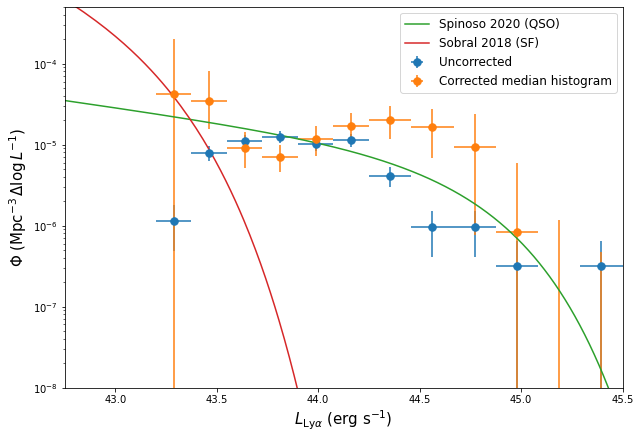

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))

yerr_cor_plus = (total_hist_cor + L_LF_err_plus ** 2) ** 0.5\
     / volume / bin_width
yerr_cor_minus = (total_hist_cor + L_LF_err_minus ** 2) ** 0.5\
     / volume / bin_width
xerr = bin_width / 2

ax.errorbar(LF_bins, total_hist / volume / bin_width,
    yerr= total_hist ** 0.5 / volume / bin_width,
    xerr=xerr,
    marker='.', linestyle='', markersize=15, label='Uncorrected')
# ax.errorbar(LF_bins + 0.007, total_hist_cor / volume / bin_width,
#     yerr= [yerr_cor_minus, yerr_cor_plus],
#     xerr=xerr,
#     marker='.', linestyle='', markersize=15, label='Corrected')
yerr_cor_plus = (hist_median + L_LF_err_plus ** 2) ** 0.5\
     / volume / bin_width
yerr_cor_minus = (hist_median + L_LF_err_minus ** 2) ** 0.5\
     / volume / bin_width
xerr = bin_width / 2
ax.errorbar(LF_bins, hist_median / volume / bin_width,
    yerr= [yerr_cor_minus, yerr_cor_plus], xerr=xerr,
    marker='.', linestyle='', markersize=15, label='Corrected median histogram')

Lx = np.linspace(10 ** 42, 10 ** 46, 10000)
phistar1 = 3.33e-6
Lstar1 = 10 ** 44.65
alpha1 = -1.35
Phi1 = schechter(Lx, phistar1, Lstar1, alpha1) * Lx * np.log(10)

phistar2 = 10 ** -3.45
Lstar2 = 10 ** 42.93
alpha2 = -1.93
Phi2 = schechter(Lx, phistar2, Lstar2, alpha2) * Lx * np.log(10)

ax.plot(np.log10(Lx), Phi1, label='Spinoso 2020 (QSO)')
ax.plot(np.log10(Lx), Phi2, label='Sobral 2018 (SF)')

ax.set_yscale('log')
ax.set_xlabel(r'$L_{\mathrm{Ly}\alpha}$ (erg s$^{-1}$)', fontsize=15)
ax.set_ylabel(r'$\Phi$ (Mpc$^{-3}\,\Delta\logL^{-1}$)',
    fontsize=15)
ax.set_ylim(1e-8, 5e-4)
ax.set_xlim(42.75, 45.5)
ax.legend(fontsize=12)

plt.show()

In [22]:
total_hist

array([ 3, 21, 29, 33, 27, 30, 13,  3,  3,  1,  0,  1])

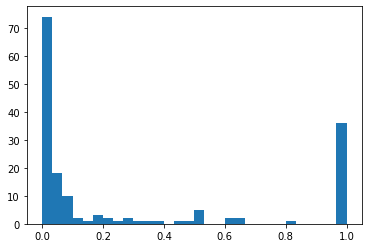

In [23]:
plt.hist(cat['morph_prob_star'][nice_lya], 30)
plt.show()